In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk
%matplotlib inline

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('./achieve/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Sentiment Analysis with TFIDF and Random Forest

This notebook creates a Random Forest Classifier for Sentiment Analysis using NLP techniques and TFIDF features. The dataset used consists of movie reviews from IMDB that have been labelled with a positive (1) or negative(0) label.

This notebook includes the following:
1. Dataset splitting
2. WordClouds
3. Text pre-processing and cleaning
4. Vectorizing with Tfidf
5. Random Forest classification
6. Hyperparameter tuning using GridSearchCV
7. Evaluation of Validation and Test Set
8. Most significant features for prediction

First, we will see what's in our dataset.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    40000 non-null  object
 1   label   40000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 625.1+ KB
None
(40000, 2)
                                                text  label
0  I grew up (b. 1965) watching and loving the Th...      0
1  When I put this movie in my DVD player, and sa...      0
2  Why do people who do not know what a particula...      0
3  Even though I have great interest in Biblical ...      0
4  Im a die hard Dads Army fan and nothing will e...      1
5  A terrible movie as everyone has said. What ma...      0
6  Finally watched this shocking movie last night...      1
7  I caught this film on AZN on cable. It sounded...      0
8  It may be the remake of 1987 Autumn's Tale aft...      1
9  My Super Ex Girlfriend turned out to be a plea...      1


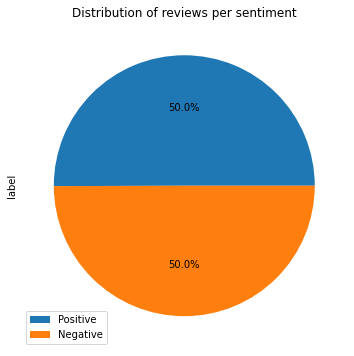

In [3]:
imdb=pd.read_csv('./archive/Train.csv')
print(imdb.info())
print(imdb.shape)
print(imdb.head(10))

imdb['label'].value_counts().plot.pie(figsize=(6,6),title="Distribution of reviews per sentiment",labels=['',''],autopct='%1.1f%%')
labels=["Positive","Negative"]
plt.legend(labels,loc=3)
plt.gca().set_aspect('equal')

We can see there are 40000 entries and there's not a single null value. The dataset comprises movie reviews with a positive (1) or negative (0) value equally distributed. SInce there are too many examples for our computation capacity, we'll split the dataset and reduce it. 

First, we'll reduce the data set to 10% and then we'll keep 50% for the training set and 25% both for the validation and the test set.

In [4]:
from sklearn.model_selection import train_test_split

features = imdb.drop("label",axis=1)
labels = imdb["label"]

X_train, X_test, y_train, y_test = train_test_split(features,labels,test_size = 0.90, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_train,y_train,test_size = 0.5, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test,y_test,test_size = 0.5, random_state=42)

print("Data distribution:\n- Train: {} \n- Validation: {} \n- Test: {}".format(len(y_train),len(y_val),len(y_test)))

Data distribution:
- Train: 2000 
- Validation: 1000 
- Test: 1000



Now let's create a function that will pre-process and clean the data. It does the following:
* Tokenize sentences
* Remove capital letters
* Remove stopwords
* Remove non-alphanumeric characters
* Lemmatize the tokens

In [5]:
def clean(text):
    wn = nltk.WordNetLemmatizer()
    stopword = nltk.corpus.stopwords.words('english')
    tokens = nltk.word_tokenize(text)
    lower = [word.lower() for word in tokens]
    no_stopwords = [word for word in lower if word not in stopword]
    no_alpha = [word for word in no_stopwords if word.isalpha()]
    lemm_text = [wn.lemmatize(word) for word in no_alpha]
    clean_text = lemm_text
    return clean_text

Now that we've cleaned our data, let's explore it.

We create lists for positive and negative words and then visualize the most common ones with WordClouds.

In [6]:
from wordcloud import WordCloud
from collections import Counter

def generate_wordcloud(words,sentiment):
    plt.figure(figsize=(16,13))
    wc = WordCloud(background_color="white", max_words=100, max_font_size=50)
    wc.generate(words)
    plt.title("Most common {} words".format(sentiment), fontsize=20)
    plt.imshow(wc.recolor(colormap='Pastel2', random_state=17), alpha=0.98)
    plt.axis('off')
    
imdb=imdb.head(1000)
print("Processing data...")
imdb['clean']=imdb['text'].map(clean)
imdb['clean_text']=imdb['clean'].apply(lambda x: " ".join([str(word) for word in x]))

print("Creating word clouds...")
positive_words=" ".join(imdb[imdb.label==1]['clean_text'].values)
negative_words=" ".join(imdb[imdb.label==0]['clean_text'].values)

generate_wordcloud(positive_words,"positive")
generate_wordcloud(negative_words,"negative")

ModuleNotFoundError: No module named 'wordcloud'

Now that we explored our data, this function will turn it into a matrix for our analysis by using the TfidfVectorizer.

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer

def vectorize(data,tfidf_vect_fit):
    X_tfidf = tfidf_vect_fit.transform(data)
    words = tfidf_vect_fit.get_feature_names()
    X_tfidf_df = pd.DataFrame(X_tfidf.toarray())
    X_tfidf_df.columns = words
    return(X_tfidf_df)

In [8]:
tfidf_vect = TfidfVectorizer(analyzer=clean)
tfidf_vect_fit=tfidf_vect.fit(X_train['text'])
X_train=vectorize(X_train['text'],tfidf_vect_fit)

We explore first results of a Random Forest Classifier without any hyperparameter tuning using 5-cross-fold validation.

In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

rf = RandomForestClassifier()
scores = cross_val_score(rf,X_train,y_train.values.ravel(),cv=5)

In [10]:
print(scores)
scores.mean()

[0.82   0.785  0.7975 0.815  0.7875]


0.8009999999999999

In [17]:
X_train.columns

Index(['aaaahhhhhhh', 'aag', 'aaliyah', 'aamir', 'aaron', 'aawip', 'ab',
       'abandon', 'abandoned', 'abandonment',
       ...
       'zzzz', 'zzzzzzzz', 'zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz',
       'zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz',
       'zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz', 'zübert', 'à', 'ís',
       'óli', 'über'],
      dtype='object', length=21657)

In [16]:
print(X_train.iloc[0])

aaaahhhhhhh    0.0
aag            0.0
aaliyah        0.0
aamir          0.0
aaron          0.0
              ... 
zübert         0.0
à              0.0
ís             0.0
óli            0.0
über           0.0
Name: 0, Length: 21657, dtype: float64


Now we'll do some hyperparameter tuning using GridSearchCV.

In [46]:
def print_results(results):
    print('BEST PARAMS: {}\n'.format(results.best_params_))

    means = results.cv_results_['mean_test_score']
    stds = results.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, results.cv_results_['params']):
        print('{} (+/-{}) for {}'.format(round(mean, 3), round(std * 2, 3), params))

In [47]:
from sklearn.model_selection import GridSearchCV

rf = RandomForestClassifier()
parameters = {
    'n_estimators': [5,50,100],
    'max_depth': [2,10,20,None]
}

cv = GridSearchCV(rf,parameters)
cv.fit(X_train,y_train.values.ravel())
print_results(cv)

BEST PARAMS: {'max_depth': 20, 'n_estimators': 100}

0.551 (+/-0.058) for {'max_depth': 2, 'n_estimators': 5}
0.677 (+/-0.066) for {'max_depth': 2, 'n_estimators': 50}
0.742 (+/-0.047) for {'max_depth': 2, 'n_estimators': 100}
0.641 (+/-0.034) for {'max_depth': 10, 'n_estimators': 5}
0.758 (+/-0.035) for {'max_depth': 10, 'n_estimators': 50}
0.776 (+/-0.043) for {'max_depth': 10, 'n_estimators': 100}
0.65 (+/-0.08) for {'max_depth': 20, 'n_estimators': 5}
0.774 (+/-0.049) for {'max_depth': 20, 'n_estimators': 50}
0.8 (+/-0.052) for {'max_depth': 20, 'n_estimators': 100}
0.638 (+/-0.043) for {'max_depth': None, 'n_estimators': 5}
0.784 (+/-0.03) for {'max_depth': None, 'n_estimators': 50}
0.794 (+/-0.039) for {'max_depth': None, 'n_estimators': 100}


In [48]:
cv.best_estimator_

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

For the evaluation of the validation set, first we need to transform it using the same features as the training set. Then, we can evaluate our best models from CV on it.

In [76]:
X_val=vectorize(X_val['text'],tfidf_vect_fit)

In [70]:
rf1 = RandomForestClassifier(n_estimators=100,max_depth=20)
rf1.fit(X_train, y_train.values.ravel())
rf2 = RandomForestClassifier(n_estimators=100,max_depth=None)
rf2.fit(X_train, y_train.values.ravel())
rf3 = RandomForestClassifier(n_estimators=5,max_depth=None)
rf3.fit(X_train, y_train.values.ravel())

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=5,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [78]:
from sklearn.metrics import accuracy_score,precision_score,recall_score

for mdl in [rf1,rf2,rf3]:
    y_pred = mdl.predict(X_val)
    accuracy = round(accuracy_score(y_val,y_pred), 3)
    precision = round(precision_score(y_val,y_pred), 3)
    recall = round(recall_score(y_val,y_pred), 3)
    print('MAX DEPTH: {} / # OF EST: {} -- A: {} / P: {} / R: {}'.format(mdl.max_depth,
                                                                         mdl.n_estimators,
                                                                         accuracy,
                                                                         precision,
                                                                         recall))


MAX DEPTH: 20 / # OF EST: 100 -- A: 0.81 / P: 0.804 / R: 0.808
MAX DEPTH: None / # OF EST: 100 -- A: 0.815 / P: 0.814 / R: 0.806
MAX DEPTH: None / # OF EST: 5 -- A: 0.686 / P: 0.692 / R: 0.644


Finally, we can see the the best model is the second one:

**MAX DEPTH: None / # OF EST: 100**

So now we will evaluate the best model on the test set.

In [80]:
X_test=vectorize(X_test['text'],tfidf_vect_fit)

y_pred = rf2.predict(X_test)
accuracy = round(accuracy_score(y_test,y_pred), 3)
precision = round(precision_score(y_test,y_pred), 3)
recall = round(recall_score(y_test,y_pred), 3)
print('MAX DEPTH: {} / # OF EST: {} -- A: {} / P: {} / R: {}'.format(rf3.max_depth,
                                                                     rf3.n_estimators,
                                                                     accuracy,
                                                                     precision,
                                                                     recall))

MAX DEPTH: None / # OF EST: 5 -- A: 0.835 / P: 0.845 / R: 0.804


Now we can explore and see what are the most important words to predict the correct results.

In [20]:
rf.fit(X_train,y_train.values.ravel())

RandomForestClassifier()

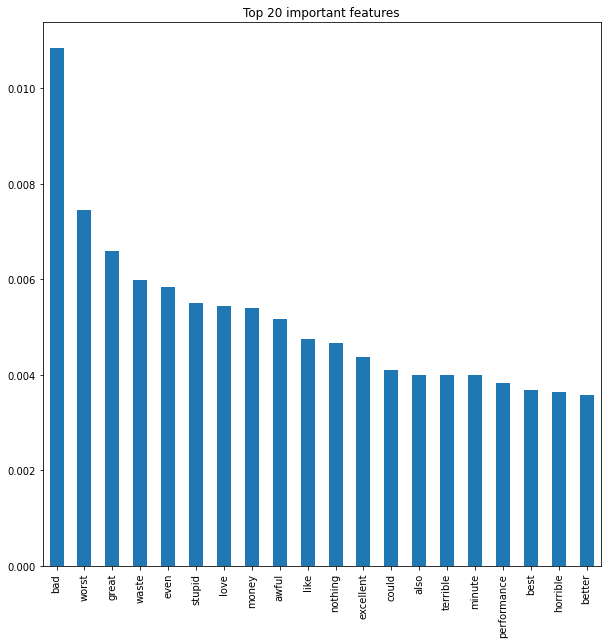

In [21]:
feat_importances = pd.Series(rf.feature_importances_, index=X_train.columns)
feat_importances.nlargest(20).plot(kind='bar',figsize=(10,10))
plt.title("Top 20 important features")
plt.show()